## Final Project - Diagnosis Diabetes with Classification Algorithms
#### Team members: Lin Xinyang, Shivam Varshney

#### Project description:
In this project, we will use different machine learning algorithms to solve a classification problem -- diabetes diagnosis in the female group. The dataset we utilize is called "diabetes" from Analytics Vidhya and it includes eight essential diabetes indicators. We will encompass approximate six steps in this project, each of which plays a different role in deciphering the inherent patterns of the data selected. On top of that, we will measure performance of different models and give the award to the one with the optimal predictive results. We sincerely hope this project can give you insight into the mechanism of these algorithms and machine learning's applications in real world.  

### Section one: import libraries and dataset

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install mlxtend
!pip install missingno
from mlxtend.plotting import plot_decision_regions
import missingno as msno
from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [106]:
!pip install xgboost
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import scipy.stats as stats
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [10]:
diabetes_df = pd.read_csv('diabetes.csv')

### Section two: data preprocessing

#### (1) Overall of the data

In [17]:
diabetes_df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


#### (2) Data Cleaning - handle missing values

In [24]:
print(diabetes_df.isnull().sum())
print(diabetes_df.info())
# Fortunately, the answer is no! But wait! Do you notice many zeros in columns BloodPressure,SkinThickness,Insulin,BMI?
# These indicators cannot be zeors. Therefore, there are actually missing values in the dataset

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: 

In [37]:
# Replace missing values with column medians
diabetes_df_copy = diabetes_df.copy(deep = True)
columns_median=np.array([np.median(diabetes_df_copy["Glucose"]),
                         np.median(diabetes_df_copy["BloodPressure"]),
                         np.median(diabetes_df_copy["SkinThickness"]),
                        np.median(diabetes_df_copy["Insulin"]),
                         np.median(diabetes_df_copy["BMI"])])

diabetes_df_copy.loc[diabetes_df_copy["Glucose"]==0,"Glucose"]= columns_median[0]
diabetes_df_copy.loc[diabetes_df_copy["BloodPressure"]==0,"BloodPressure"]= columns_median[1]
diabetes_df_copy.loc[diabetes_df_copy["SkinThickness"]==0,"SkinThickness"]= columns_median[2]
diabetes_df_copy.loc[diabetes_df_copy["Insulin"]==0,"Insulin"]= columns_median[3]
diabetes_df_copy.loc[diabetes_df_copy["BMI"]==0,"BMI"]= columns_median[4]

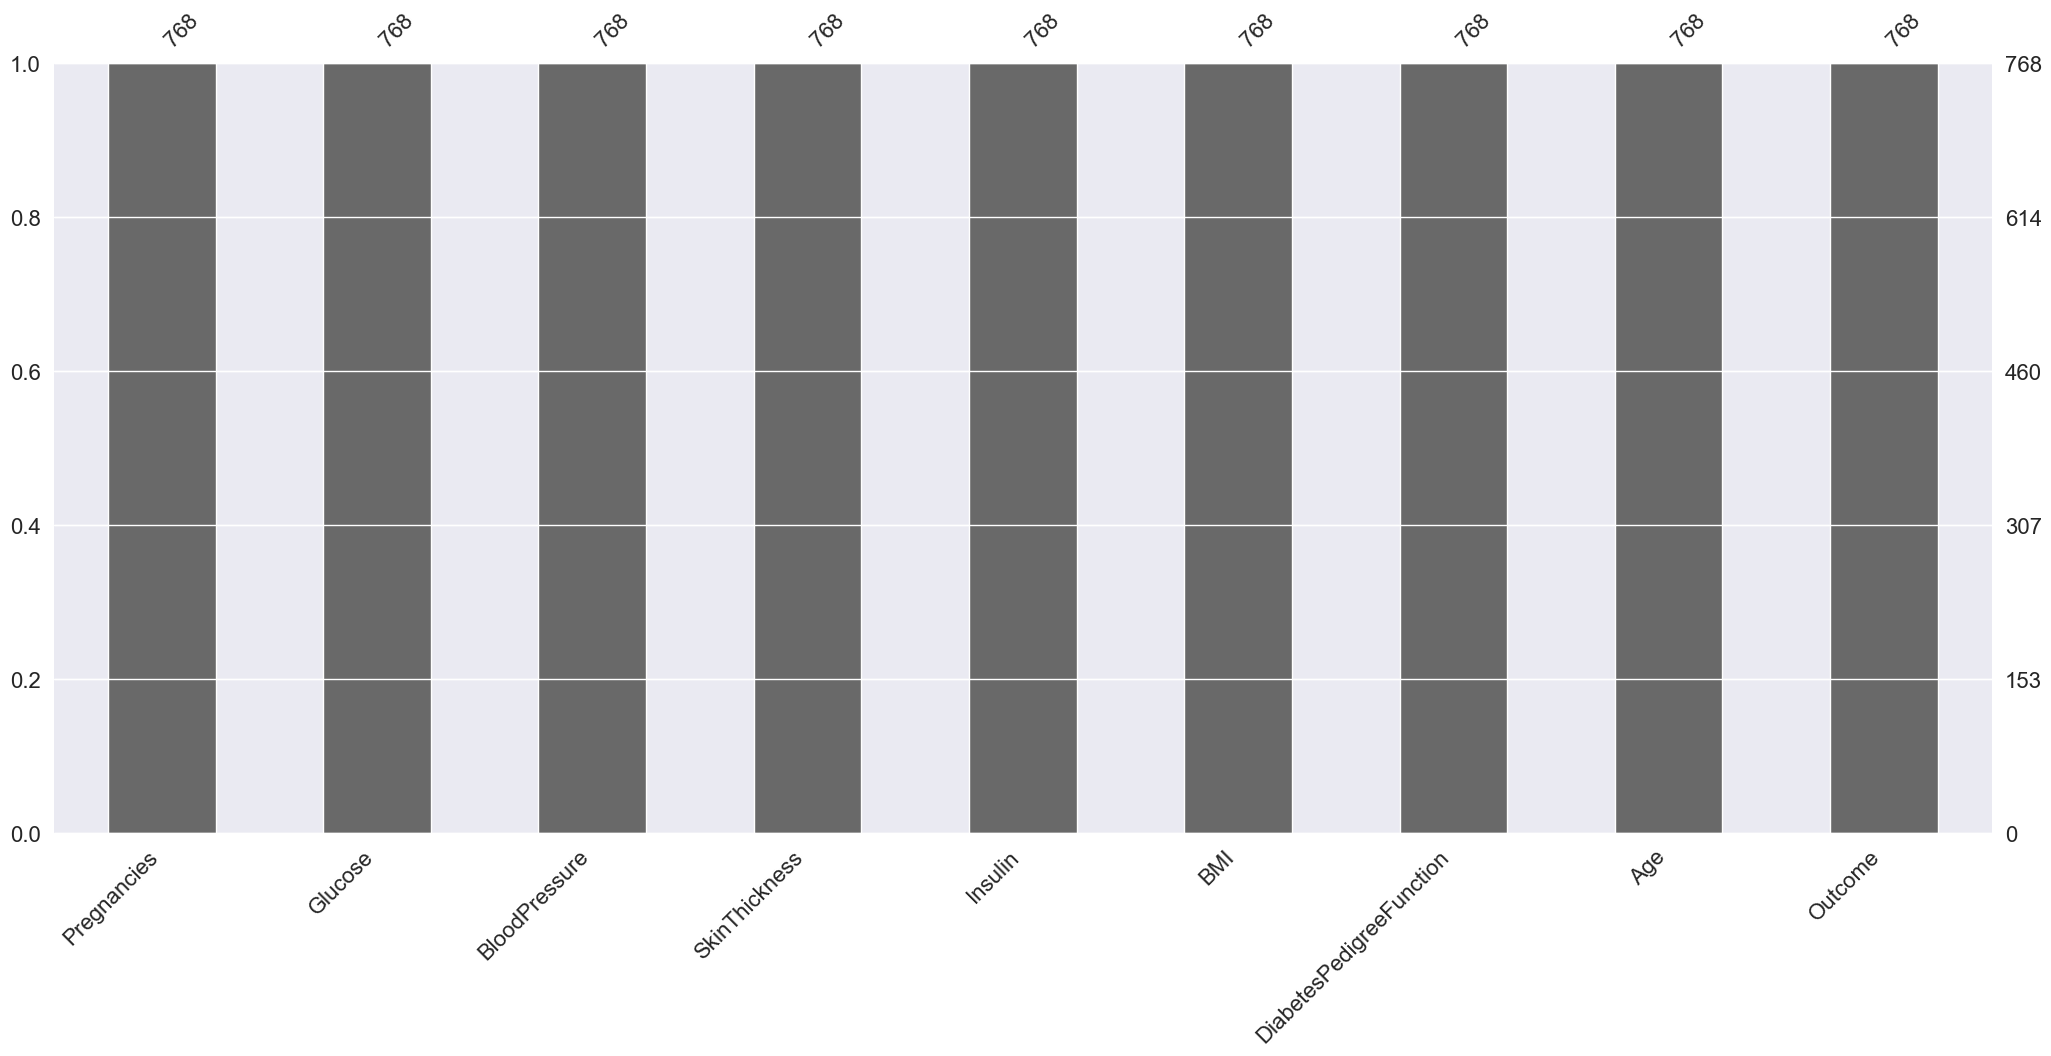

In [47]:
#Plotting Null Count Analysis Plot
p = msno.bar(diabetes_df_copy)

#### (3) Statistical description

In [39]:
diabetes_df_copy.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Section three: Data visualization

In this section, we will visualize features in the dataset, and in the whole process, we may also perform feature selection and data scaling.

#### (1) Histgram: distribution of each feature

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

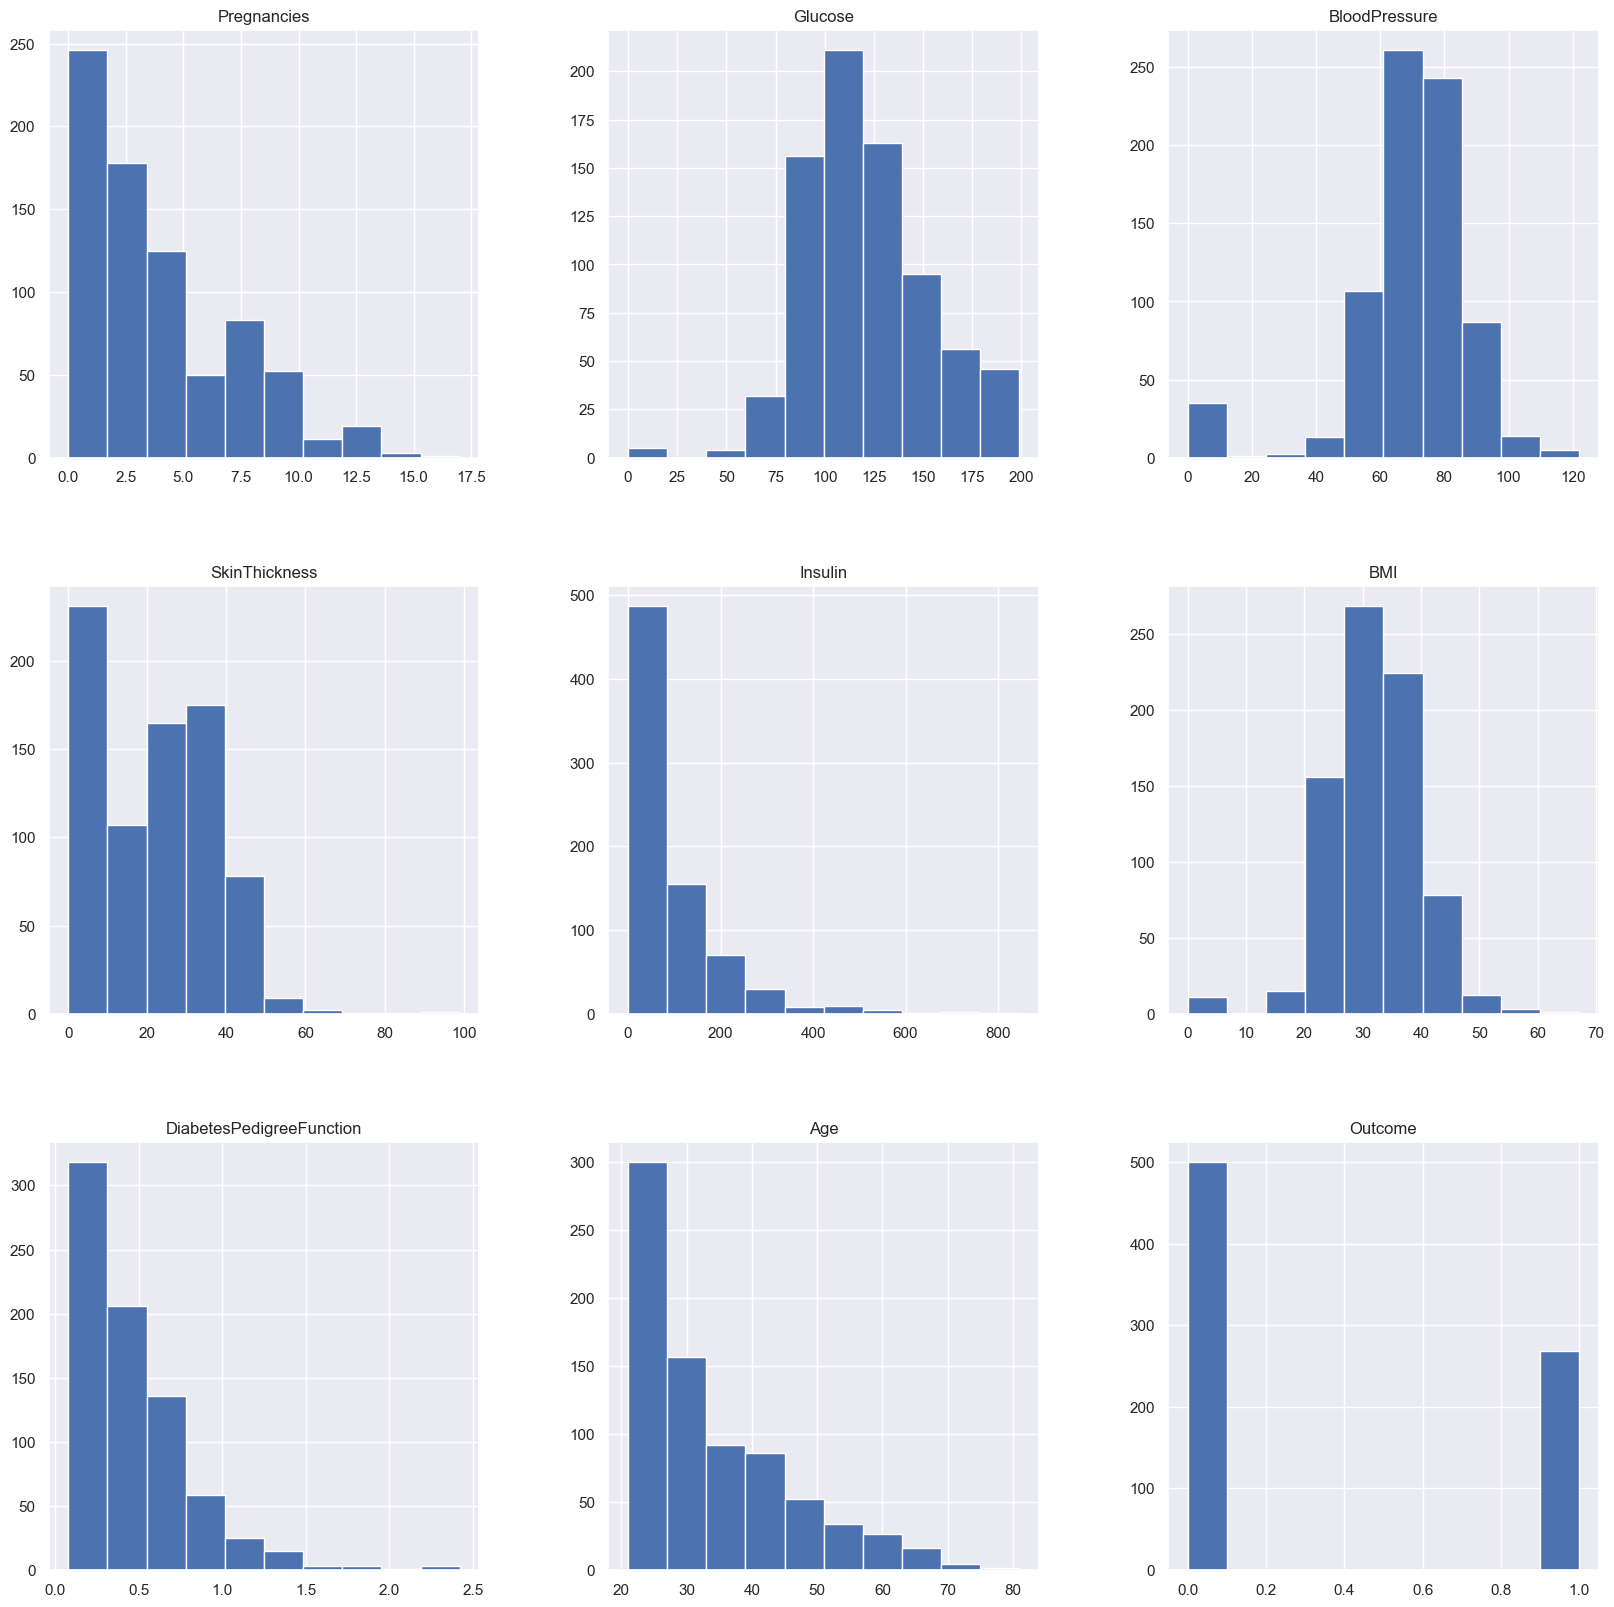

In [41]:
diabetes_df.hist(figsize = (20,20))

#### Inference:
(1) Only Glucose, BloodPressure, BMI seem to follow Gaussian distribution. The rest of features are left skewed. 

(2) Most women are pregnant fewer than five times. Their glucose level concentrates between 75 and 150. Most of their blood pressure is around 60 t0 80. Insulin level between 0 and 100 stands out. BMI from 30 to 40 is a good representative of this group (A person can be considered obese if his/her BMI is higher than 30, which is the international standard). A very large number of them age between 20 to 30.

#### (2) QQ plot: examination of Gaussian distribution

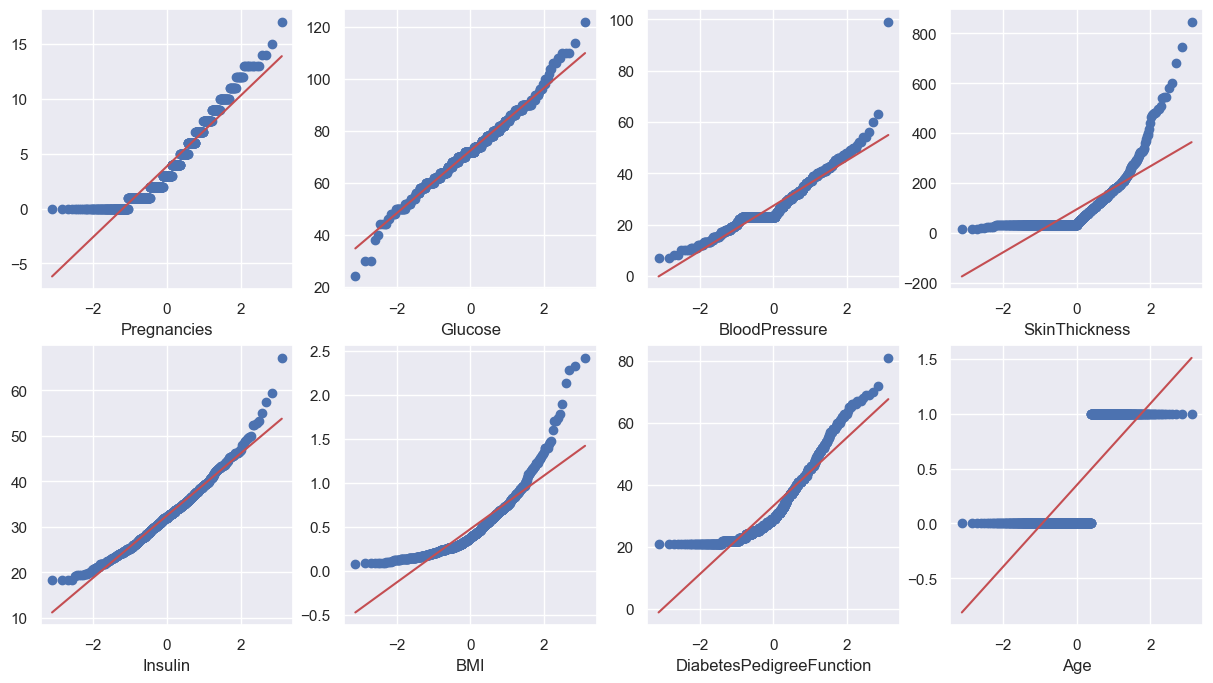

In [43]:
feature_names = [
    "Pregnancies", "Glucose", "BloodPressure",
    "SkinThickness", "Insulin", "BMI",
    "DiabetesPedigreeFunction", "Age", "Outcome"
]

indices=[0,2,3,4,5,6,7,8]

fig,axes=plt.subplots(2,4,figsize=(15,8))
axes=axes.flatten()
for i,index in enumerate(indices):
    ax=axes[i]
    stats.probplot(diabetes_df_copy.iloc[:, index], dist="norm", plot=ax)
    ax.set_title("")
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel("")
plt.show()

#### Inference:
Based on QQ plots above, we could observe that Glucose, Blood pressure and Insulin are mostly likely to follow normal distribution. Regarding the rest features, there exists obvious deviation from the red line in the beginning and tail. 

#### (3) Heatmap: correlation between features

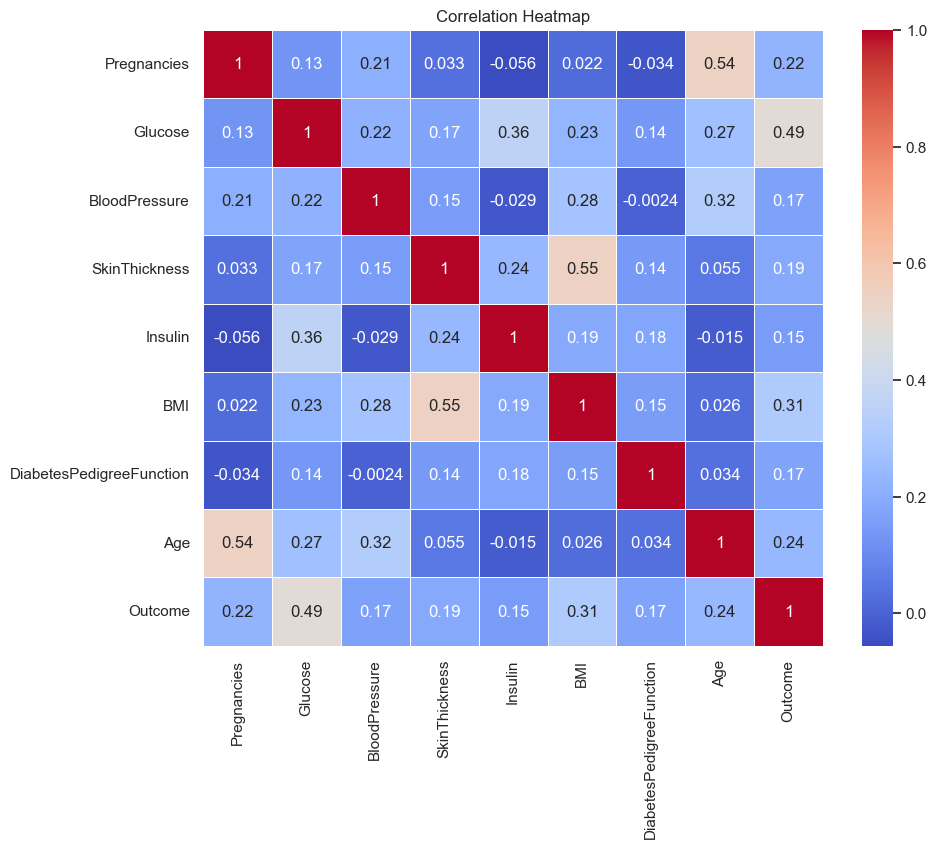

In [49]:
# Correlation heatmap
df = diabetes_df_copy.copy()  # If needed, create a copy of the DataFrame
x_labels=["Pregnancies", "Glucose", "BloodPressure",
    "SkinThickness", "Insulin", "BMI",
    "DiabetesPedigreeFunction", "Age", "Outcome"
]
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, xticklabels=x_labels, yticklabels=x_labels)
plt.title("Correlation Heatmap")
plt.show()

In [48]:
# Correlation coefficient between explanatory variables and the output:
corrcoef_dict = {}
features = diabetes_df_copy.shape[1]
feature_names = [
    "Pregnancies", "Glucose", "BloodPressure",
    "SkinThickness", "Insulin", "BMI",
    "DiabetesPedigreeFunction", "Age", "Outcome"
]

for j in range(features):
    coreffi = np.corrcoef(diabetes_df_copy.iloc[:, j], diabetes_df_copy['Outcome'])
    corrcoef_dict[feature_names[j]] = coreffi

print(f"The correlation coefficient between each feature and the target: {corrcoef_dict}")

The correlation coefficient between each feature and the target: {'Pregnancies': array([[1.        , 0.22189815],
       [0.22189815, 1.        ]]), 'Glucose': array([[1.       , 0.4927824],
       [0.4927824, 1.       ]]), 'BloodPressure': array([[1.        , 0.16572291],
       [0.16572291, 1.        ]]), 'SkinThickness': array([[1.        , 0.18906542],
       [0.18906542, 1.        ]]), 'Insulin': array([[1.        , 0.14845724],
       [0.14845724, 1.        ]]), 'BMI': array([[1.        , 0.31224903],
       [0.31224903, 1.        ]]), 'DiabetesPedigreeFunction': array([[1.        , 0.17384407],
       [0.17384407, 1.        ]]), 'Age': array([[1.        , 0.23835598],
       [0.23835598, 1.        ]]), 'Outcome': array([[1., 1.],
       [1., 1.]])}


#### Inference:
It seems that all these features make certain contribution to the output value, so let's not remove any of them.

#### (4) Bar chart: balance of outcomes

0    500
1    268
Name: Outcome, dtype: int64


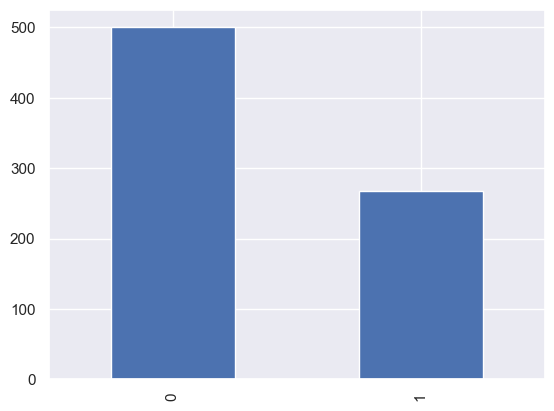

In [50]:
#Now, let’s check that how well our outcome column is balanced
color_wheel = {1: "#0392cf", 2: "#7bc043"}
colors = diabetes_df["Outcome"].map(lambda x: color_wheel.get(x + 1))
print(diabetes_df.Outcome.value_counts())
p=diabetes_df.Outcome.value_counts().plot(kind="bar")

#### Inference: 
Here from the above visualization it is clearly visible that our dataset is imbalanced due to the fact that the number of patients who are diabetic is half of the patients who are non-diabetic.


#### (5) Box plot: check outliers

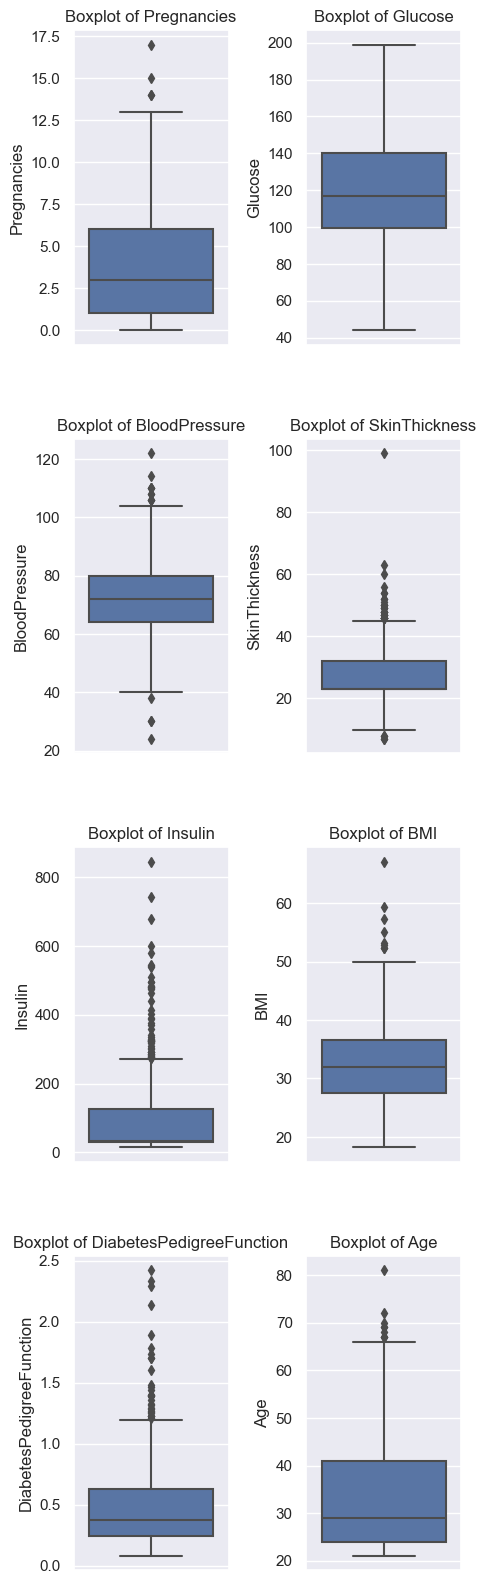

In [76]:
diabete_features=["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]

fig,axes=plt.subplots(4,2,figsize=(5,20))
axes=axes.flatten()
plt.subplots_adjust(wspace=0.5,hspace=0.3)
for i,feature in enumerate(diabete_features):
    sns.boxplot(y=diabetes_df_copy[feature],ax=axes[i])
    axes[i].set_title(f"Boxplot of {feature}")
plt.show()

#### Inference:
Glucose is the only feature that doesn't have outliers

#### (4) Scaling the Data

In [84]:
sc_X = StandardScaler()
diabetes_scaled =  pd.DataFrame(sc_X.fit_transform(diabetes_df_copy.drop(["Outcome"],axis = 1),), columns=['Pregnancies', 
'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
diabetes_scaled["Outcome"]=diabetes_df_copy["Outcome"]
diabetes_scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.866045,-0.031990,0.831114,-0.608201,0.167240,0.468492,1.425995,1
1,-0.844885,-1.205066,-0.528319,0.180566,-0.608201,-0.851551,-0.365061,-0.190672,0
2,1.233880,2.016662,-0.693761,-0.469981,-0.608201,-1.331838,0.604397,-0.105584,1
3,-0.844885,-1.073567,-0.528319,-0.469981,-0.006185,-0.633239,-0.920763,-1.041549,0
4,-1.141852,0.504422,-2.679076,0.831114,0.695378,1.549885,5.484909,-0.020496,1


### Section four: building models

In this section, we will build Logistic Regression, Decision Trees, Random Forest, AdaBoost, XGBoost and Support Vector Machine to make prediction 

#### (1) Logistic Regression

In [114]:
# extract features we will use
X = diabetes_scaled[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
y = diabetes_scaled[['Outcome']] 

# data splitting
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# model building
model = LogisticRegression(penalty="l2",max_iter=100,solver="lbfgs",random_state=42)
model.fit(X_train,y_train)

# make prediction
y_estimated=model.predict(X_test)

# model evaluation
print("Accuracy: ",accuracy_score(y_test,y_estimated))
print("\nConfusion Matrix: ",confusion_matrix(y_test,y_estimated))
print("\nClassification report: ",classification_report(y_test,y_estimated))

Accuracy:  0.7662337662337663

Confusion Matrix:  [[82 17]
 [19 36]]

Classification report:                precision    recall  f1-score   support

           0       0.81      0.83      0.82        99
           1       0.68      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.77       154



#### (2) Random Forests

In [108]:
# let's select a model with the optimal parameters
n_estimators=[20,30,40,50,70,80,90,100,120]
max_depth=np.arange(10,30)
accuracy_matrix=np.zeros([len(n_estimators),len(max_depth)])

for i,estimator in enumerate(n_estimators):
    for j,depth in enumerate(max_depth):
        rf_model=RandomForestClassifier(n_estimators=estimator,max_depth=depth)
        rf_model.fit(X_train,y_train)
        y_estimated=rf_model.predict(X_test)
        accuracy_matrix[i,j]=accuracy_score(y_test,y_estimated)

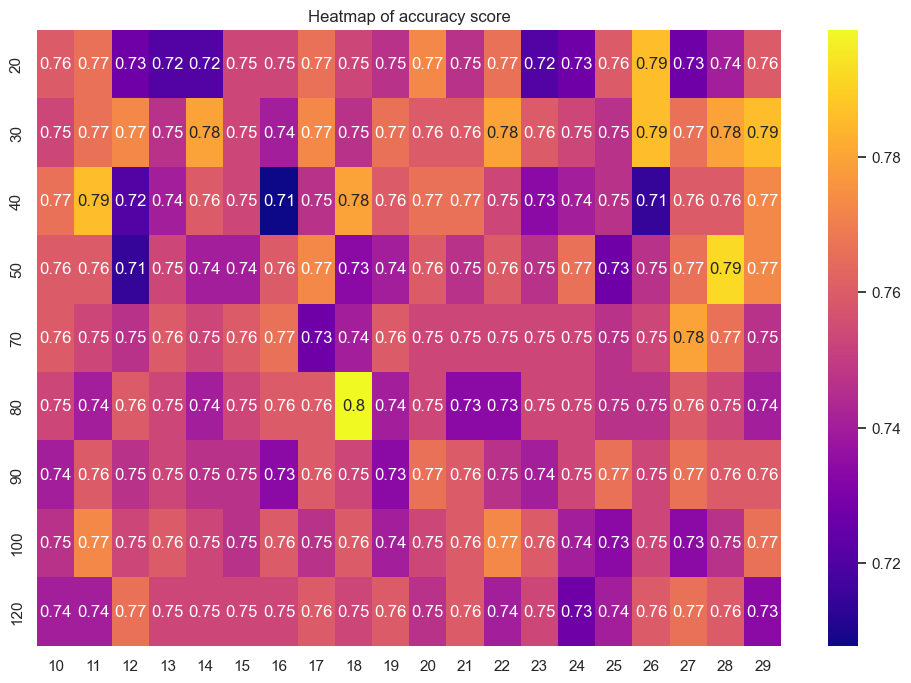

The best Random Forest model can be produced when n_estimators is 80 and max_depth is 18. The accuracy score in this case is  0.7987012987012987


In [113]:
# let's plot heatmap for accuracy_matrix

plt.figure(figsize=(12,8))
sns.heatmap(accuracy_matrix,cmap="plasma",annot=True,xticklabels=max_depth,yticklabels=n_estimators)
plt.title("Heatmap of accuracy score")
plt.show()

print("The best Random Forest model can be produced when n_estimators is 80 and max_depth is 18. The accuracy score in this case is ",np.max(accuracy_matrix))

#### (3) AdaBoost

In [116]:
base_classifier=DecisionTreeClassifier(max_depth=2)
n_estimators=[20,30,40,50,70,80,90,100,120]
learning_rate=[0.01,0.02,0.05,0.1,1]

accuracy_matrix2=np.zeros([len(n_estimators),len(learning_rate)])

for i, estimator in enumerate(n_estimators):
    for j, rate in enumerate(learning_rate):
        adaboost_class=AdaBoostClassifier(base_estimator=base_classifier,
                                          n_estimators=estimator,
                                          learning_rate=rate,
                                          random_state=42)
        adaboost_class.fit(X_train,y_train)
        y_estimated=adaboost_class.predict(X_test)
        accuracy_matrix2[i,j]=accuracy_score(y_test,y_estimated)

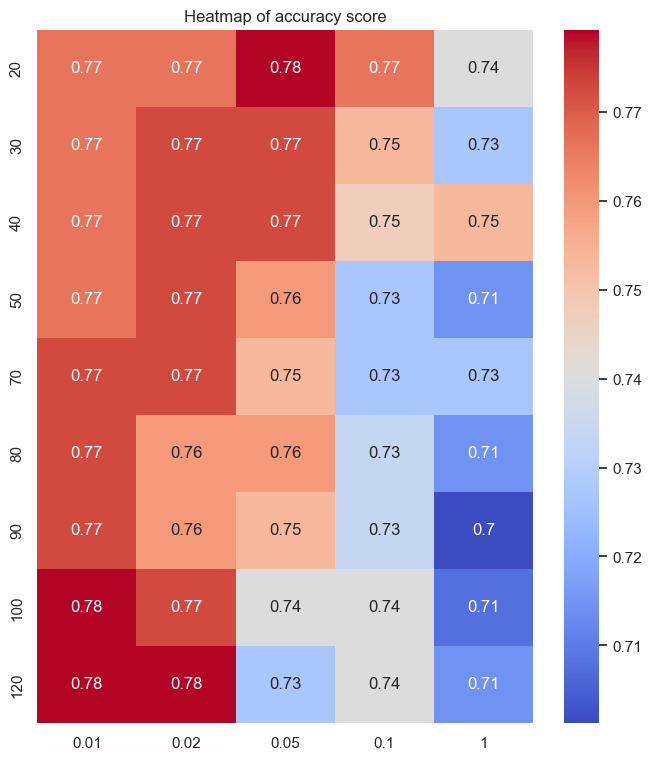

The best Random Forest model can be produced when n_estimators is 20,100, or 120 and learning_rate is 0.01,0.02 or 0.05. The accuracy score in this case is  0.7792207792207793


In [122]:
# let's plot heatmap once again
plt.figure(figsize=(8,9))
sns.heatmap(accuracy_matrix2,cmap="coolwarm",annot=True,xticklabels=learning_rate,yticklabels=n_estimators)
plt.title("Heatmap of accuracy score")
plt.show()

print("The best Random Forest model can be produced when n_estimators is 20,100, or 120 and learning_rate is 0.01,0.02 or 0.05. The accuracy score in this case is ",np.max(accuracy_matrix2))